# Train a Quantized CNN on MNIST with Brevitas

<font color="red">**Live FINN tutorial:** We recommend clicking **Cell -> Run All** when you start reading this notebook for "latency hiding".</font>

In this notebook, we will show how to create, train and export a quantized Multi Layer Perceptron (MLP) with quantized weights and activations with [Brevitas](https://github.com/Xilinx/brevitas).

**You won't need a GPU to train the neural net.** This MLP will be small enough to train on a modern x86 CPU, so no GPU is required to follow this tutorial  Alternatively, we provide pre-trained parameters for the MLP if you want to skip the training entirely.


## A quick introduction to the task and the dataset

*Performance considerations:* FPGAs are commonly used for implementing high-performance packet processing systems that still provide a degree of programmability. To avoid introducing bottlenecks on the network, the DNN implementation must be capable of detecting malicious ones at line rate, which can be millions of packets per second, and is expected to increase further as next-generation networking solutions provide increased
throughput. This is a good reason to consider FPGA acceleration for this particular use-case.

## Outline
-------------

* [Load Dataset](#load_dataset) 
* [Define the Quantized MLP Model](#define_quantized_mlp)
* [Define Train and Test  Methods](#train_test)
    * [(Option 1) Train the Model from Scratch](#train_scratch)
    * [(Option 2) Load Pre-Trained Parameters](#load_pretrained)
* [Network Surgery Before Export](#network_surgery)
* [Export to FINN-ONNX](#export_finn_onnx)

In [2]:
import onnx
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

print("Using device: ", device)

Using device:  cpu


**This is important -- always import onnx before torch**. This is a workaround for a [known bug](https://github.com/onnx/onnx/issues/2394).

## Set up DataLoader

Following either option, we now have access to the quantized dataset. We will wrap the dataset in a PyTorch `DataLoader` for easier access in batches.

In [214]:
## Load dataset
import numpy as np
import cv2
import os
import struct
from torch.utils.data import DataLoader, Dataset
from torch.utils.data import TensorDataset
from random import randrange
import copy


print("Loading dataset")

#none_img_dir = "/home/nm/Downloads/VOCdevkit/VOC2012/single_or_no_person_dataset/no_person_images"
one_img_dir = "./single_person_images"
#none_txt_dir = "/home/nm/Downloads/VOCdevkit/VOC2012/single_or_no_person_dataset/no_person_txt"
one_txt_dir = "./single_person_txt"


train_images = []
train_labels = []
test_images = []
test_labels = []

temp_label = []


# ---------------------------------#

orig_img_size = 500
resized_size = 100

color = 1 ## 1 = color, 0 = grayscale

with_personless = 0 ## 1 = include images without people

augment_ratio = 0.1 #5.9 ## higher number = bigger augmented dataset

# ---------------------------------#

if with_personless == 0:
    range_i = 1
if with_personless == 1:
    range_i = 2

dims = (resized_size, resized_size) #(256,256) # dimensions of images to train/test with

label_scale = dims[0] / orig_img_size

## KEEP IN MIND GRAYSCALE, INCLUDE COLORS (3x channels) 

num_test = 0
num_train = 0


def to_onehot(label, n_categories, img_dim):
    n_categories = round(n_categories)
    one_hot_label = np.zeros(n_categories*4) # 4 = num classes, concat'ed multihot vector
    scaling = float(n_categories) / float(img_dim)
    for i in range(len(label)):
        # indexing starts at 1 and tensor indexing starts at 0
        label_scaled = round(label[i] * scaling)
        if label_scaled > (n_categories-1):
            label_scaled = n_categories-1
        if label_scaled < 0:
            label_scaled = 0
        one_hot_label[(label_scaled+(n_categories*i))] = float(1.0) ## -1?
    return one_hot_label


def shift_image(img,tx,ty):  
    tmp_img = copy.deepcopy(img)
    num_rows, num_cols = tmp_img.shape[:2]
    # Creating a translation matrix
    translation_matrix = np.float32([ [1,0,tx], [0,1,ty] ])
    # Image translation
    img_translation = cv2.warpAffine(tmp_img, translation_matrix, (num_cols,num_rows))
    return img_translation


def shift_img_label(img, label, tx, ty):
    shifted_image = shift_image(img, tx, ty)
    shifted_label = copy.deepcopy(label)
    shifted_label[0] = shifted_label[0] + tx
    shifted_label[1] = shifted_label[1] + ty
    shifted_label[2] = shifted_label[2] + tx
    shifted_label[3] = shifted_label[3] + ty
    return shifted_image, shifted_label


for j in range(range_i):
    if j == 1:
        read_folder = none_img_dir + '/'
        label_folder = none_txt_dir + '/'
    if j == 0:
        read_folder = one_img_dir + '/'
        label_folder = one_txt_dir + '/'
    for filename in os.listdir(read_folder):
           
        sample_dataset = randrange(10)
        if sample_dataset > -1:#== 0:
            randint = randrange(20)
            img = cv2.imread(os.path.join(read_folder,filename),color) # read img as grayscale
            img = cv2.resize(img, dims, interpolation = cv2.INTER_AREA)# resize img to fit dims
            if color == 1:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # this converts it into RGB
            img_flipped = cv2.flip(img, 1)
            f = open(label_folder + filename.replace('.jpg','.txt'), "r")
            temp_label = (f.read().split(","))
            flipped_label = []
            for k in range (4):
                temp_label[k] = round(float(temp_label[k]) * label_scale)
                if k == 0 or k == 2:
                    flipped_label.append(resized_size-temp_label[k])
                else:
                    flipped_label.append(temp_label[k])
            tmp_lab = flipped_label[0]
            flipped_label[0] = flipped_label[2]
            flipped_label[2] = tmp_lab
            f.close()
                    
            temp_label_oh = to_onehot(temp_label, (dims[0]/10), dims[0])
            flipped_label = to_onehot(flipped_label, (dims[0]/10), dims[0])
                 
            if img is not None:
                if randrange(100) == 1:
                    if randint != 0:
                        train_images.append(np.moveaxis(np.asarray(img), -1, 0).astype('float32'))
                        train_labels.append(np.asarray(temp_label_oh).astype('float32'))
                        train_images.append(np.moveaxis(np.asarray(img_flipped), -1, 0).astype('float32'))
                        train_labels.append(np.asarray(flipped_label).astype('float32'))
                        num_train += 2   

                        corners = [0,0,0,0] # ╔ , ╗ , ╝ , ╚

                        if randrange(round(augment_ratio*10)) > 10:
                        #at least 50 px shift to the left
                            if temp_label[0] > (dims[0]*0.1):
                                corners[0] += 1
                                corners[3] += 1
                                randshift_x = randrange(round((dims[0]*0.05)), (temp_label[0]))
                                ls_img, ls_label = shift_img_label(img, temp_label, -randshift_x, 0)
                                ls_label = to_onehot(ls_label, (dims[0]/10), dims[0])
                                train_images.append(np.moveaxis(np.asarray(ls_img), -1, 0).astype('float32'))
                                train_labels.append(np.asarray(ls_label).astype('float32'))
                                num_train += 1                       

                        if randrange(round(augment_ratio*10)) > 10:
                        #at least 50 px to shift on top side
                            if temp_label[1] > (dims[0]*0.1):
                                corners[0] += 1
                                corners[1] += 1
                                randshift_y = randrange(round((dims[0]*0.05)), (temp_label[1]))
                                ts_img, ts_label = shift_img_label(img, temp_label, 0, -randshift_y)
                                ts_label = to_onehot(ts_label, (dims[0]/10), dims[0])
                                train_images.append(np.moveaxis(np.asarray(ts_img), -1, 0).astype('float32'))
                                train_labels.append(np.asarray(ts_label).astype('float32'))
                                num_train += 1    

                        if randrange(round(augment_ratio*10)) > 10:
                        #at least 50 px to shift on right side
                            if temp_label[2] < (dims[0] - (dims[0]*0.1)):
                                corners[1] += 1
                                corners[2] += 1
                                randshift_x = randrange(round((dims[0]*0.05)), (dims[0]-temp_label[2]))
                                rs_img, rs_label = shift_img_label(img, temp_label, randshift_x, 0)
                                rs_label = to_onehot(rs_label, (dims[0]/10), dims[0])
                                train_images.append(np.moveaxis(np.asarray(rs_img), -1, 0).astype('float32'))
                                train_labels.append(np.asarray(rs_label).astype('float32'))
                                num_train += 1    

                        if randrange(round(augment_ratio*10)) > 10:
                        #at least 50 px to shift on bottom side
                            if temp_label[3] < (dims[0] - (dims[0]*0.1)):
                                corners[2] += 1
                                corners[3] += 1
                                randshift_y = randrange(round((dims[0]*0.05)), (dims[0]-temp_label[3]))
                                bs_img, bs_label = shift_img_label(img, temp_label, 0, randshift_y)
                                bs_label = to_onehot(bs_label, (dims[0]/10), dims[0])
                                train_images.append(np.moveaxis(np.asarray(bs_img), -1, 0).astype('float32'))
                                train_labels.append(np.asarray(bs_label).astype('float32'))
                                num_train += 1    

                        #if randrange(2) == 1:
                        # 1st corner shift ╔
                        if corners[0] == 2:
                            randshift_x = randrange(round((dims[0]*0.05)), (temp_label[0]))
                            randshift_y = randrange(round((dims[0]*0.05)), (temp_label[1]))
                            c1_img, c1_label = shift_img_label(img, temp_label, -randshift_x, -randshift_y)
                            c1_label = to_onehot(c1_label, (dims[0]/10), dims[0])
                            train_images.append(np.moveaxis(np.asarray(c1_img), -1, 0).astype('float32'))
                            train_labels.append(np.asarray(c1_label).astype('float32'))
                            num_train += 1    

                        #if randrange(2) == 1:
                        if corners[1] == 2:
                            randshift_x = randrange(round((dims[0]*0.05)), (dims[0]-temp_label[2]))
                            randshift_y = randrange(round((dims[0]*0.05)), (temp_label[1]))
                            c2_img, c2_label = shift_img_label(img, temp_label, randshift_x, -randshift_y)
                            c2_label = to_onehot(c2_label, (dims[0]/10), dims[0])
                            train_images.append(np.moveaxis(np.asarray(c2_img), -1, 0).astype('float32'))
                            train_labels.append(np.asarray(c2_label).astype('float32'))
                            num_train += 1    

                        #if randrange(2) == 1:
                        if corners[2] == 2:
                            randshift_x = randrange(round((dims[0]*0.05)), (dims[0]-temp_label[2]))
                            randshift_y = randrange(round((dims[0]*0.05)), (dims[0]-temp_label[3]))
                            c3_img, c3_label = shift_img_label(img, temp_label, randshift_x, randshift_y)
                            c3_label = to_onehot(c3_label, (dims[0]/10), dims[0])
                            train_images.append(np.moveaxis(np.asarray(c3_img), -1, 0).astype('float32'))
                            train_labels.append(np.asarray(c3_label).astype('float32'))
                            num_train += 1

                        #if randrange(2) == 1:
                        if corners[3] == 2:
                            randshift_x = randrange(round((dims[0]*0.05)), (temp_label[0]))
                            randshift_y = randrange(round((dims[0]*0.05)), (dims[0]-temp_label[3]))
                            c4_img, c4_label = shift_img_label(img, temp_label, -randshift_x, randshift_y)
                            c4_label = to_onehot(c4_label, (dims[0]/10), dims[0])
                            train_images.append(np.moveaxis(np.asarray(c4_img), -1, 0).astype('float32'))
                            train_labels.append(np.asarray(c4_label).astype('float32'))
                            num_train += 1

                    if randint == 0:
                        test_images.append(np.moveaxis(np.asarray(img), -1, 0).astype('float32'))
                        test_labels.append(np.asarray(temp_label).astype('float32'))
                        num_test += 1

                  
print("Finished loading dataset: ", num_train, " train images and ", num_test, " test images")

Loading dataset
Finished loading dataset:  48  train images and  1  test images


In [215]:
train_images = np.asarray(train_images).astype('float32')
test_images = np.asarray(test_images).astype('float32')
train_labels = np.asarray(train_labels).astype('float32')
test_labels = np.asarray(test_labels).astype('float32')

       
# dataset loaders
batch_size = 1 #20

if color == 1:
    inputs  = torch.from_numpy(train_images).clone().detach()
if color == 0:
    inputs  = torch.unsqueeze(torch.from_numpy(train_images).clone().detach(), 1)
    
targets = torch.from_numpy(train_labels).clone().detach().type(torch.FloatTensor)
dataset = TensorDataset(inputs, targets)
train_quantized_loader = DataLoader(dataset, batch_size, shuffle = True)

del train_images
del train_labels


inputs  = torch.unsqueeze(torch.from_numpy(test_images).clone().detach(), 1)
targets = torch.from_numpy(test_labels).clone().detach().type(torch.FloatTensor)
dataset = TensorDataset(inputs, targets)
test_quantized_loader = DataLoader(dataset, batch_size, shuffle = True)

del test_images
del test_labels


count = 0
for x,y in train_quantized_loader:
    print("Input shape for 1 batch: " + str(x.shape))
    print("Label shape for 1 batch: " + str(y.shape))
    count += 1
    if count == 1:
        print(x[0].type())
        print(y[0].type())
        print(x[0].shape)
        print(y[0].shape)
        break        
        
print("Dataloader created")

Input shape for 1 batch: torch.Size([1, 3, 100, 100])
Label shape for 1 batch: torch.Size([1, 40])
torch.FloatTensor
torch.FloatTensor
torch.Size([3, 100, 100])
torch.Size([40])
Dataloader created


# Define the Quantized MLP Model <a id='define_quantized_mlp'></a>

In [319]:
from brevitas.quant.scaled_int import Int8ActPerTensorFloat
from brevitas.nn import QuantLinear, QuantReLU, QuantIdentity, QuantMaxPool2d, QuantConv2d
from brevitas.quant import Int8Bias as BiasQuant
import torch.nn as nn
from torch.nn import Module
import torch.nn.functional as F

# Setting seeds for reproducibility
torch.manual_seed(0)


weight_bit_width = 4
act_bit_width = 4
in_bit_width = 4
num_classes =  round((dims[0]/10))*4

if color == 0:
    channels = 1
if color == 1:
    channels = 3


# "vgg 9" topology [64, 'M', 128, 'M', 256, 256, 'M', 256, 256, 'M',],
# M = max pool

class LowPrecisionLeNet(Module):
    def __init__(self):
        super(LowPrecisionLeNet, self).__init__()
        self.quant_inp = QuantIdentity(
            bit_width=in_bit_width, return_quant_tensor=True)
        
        
        self.conv1 = QuantConv2d(
            channels, 64, 3, weight_bit_width=weight_bit_width, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu1 = QuantReLU(
            bit_width=act_bit_width, return_quant_tensor=True)
                
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
            
        self.conv2 = QuantConv2d(
            64, 128, 3, weight_bit_width=weight_bit_width, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu2 = QuantReLU(
            bit_width=act_bit_width, return_quant_tensor=True)
        
        
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        
        
        self.conv3 = QuantConv2d(
            128, 256, 3, weight_bit_width=weight_bit_width, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu3 = QuantReLU(
            bit_width=act_bit_width, return_quant_tensor=True)
        
        self.conv4 = QuantConv2d(
            256, 256, 3, weight_bit_width=weight_bit_width, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu4 = QuantReLU(
            bit_width=act_bit_width, return_quant_tensor=True)
        
        
        self.maxpool3 = nn.MaxPool2d(2, stride=2)
        
        
        self.conv5 = QuantConv2d(
            256, 256, 3, weight_bit_width=weight_bit_width, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu5 = QuantReLU(
            bit_width=act_bit_width, return_quant_tensor=True)
        
        self.conv6 = QuantConv2d(
            256, 256, 3, weight_bit_width=weight_bit_width, bias_quant=BiasQuant, return_quant_tensor=True)
        self.relu6 = QuantReLU(
            bit_width=act_bit_width, return_quant_tensor=True)
        
        
        self.maxpool4 = nn.MaxPool2d(2, stride=2) 
        ##-------------------------------------------------------
        
        
        
        
        ##-------------------------------------------------------
        self.fc1   = QuantLinear(
            1024, 512, bias=True, weight_bit_width=weight_bit_width, bias_quant=BiasQuant, return_quant_tensor=True)
        self.dropout1 = nn.Dropout(p=0.5)
        self.relu7 = QuantReLU(
            bit_width=act_bit_width, return_quant_tensor=True)
        self.fc2   = QuantLinear(
            512, 512, bias=True, weight_bit_width=weight_bit_width, bias_quant=BiasQuant, return_quant_tensor=True)
        self.dropout2 = nn.Dropout(p=0.5)
        self.relu8 = QuantReLU(
            bit_width=act_bit_width, return_quant_tensor=True)
        self.fc3   = QuantLinear(
            512, num_classes, bias=False, weight_bit_width=weight_bit_width)


    def forward(self, x):
        out = self.quant_inp(x)
        out = self.conv1(out)
        out = self.relu1(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = self.relu2(out)
        out = self.maxpool2(out)        
        out = self.conv3(out)
        out = self.relu3(out)
        out = self.conv4(out)
        out = self.relu4(out)
        out = self.maxpool3(out)        
        out = self.conv5(out)
        out = self.relu5(out)
        out = self.conv6(out)
        out = self.relu6(out)
        out = self.maxpool4(out)
        ##------------------------------
        
        ##------------------------------
        out = out.reshape(out.shape[0], -1)
        out = self.fc1(out)
        out = self.dropout1(out)
        out = self.relu7(out)
        out = self.fc2(out)
        out = self.dropout2(out)
        out = self.relu8(out)
        out = self.fc3(out)
        return out


model = LowPrecisionLeNet()

In [321]:
#test
it = iter(train_quantized_loader)
x,y = next(it)

#x = torch.unsqueeze(x, 1)
outp = model(x)

print(outp)

tensor([[ 0.0275,  0.0577, -0.1209, -0.0513, -0.2061, -0.1182,  0.0870, -0.0348,
         -0.4122,  0.1255, -0.0962, -0.3298, -0.1191,  0.2482,  0.2134, -0.0431,
         -0.2675, -0.0174,  0.1832, -0.0156,  0.2730,  0.0046, -0.2189,  0.1713,
          0.0027,  0.1090,  0.0092, -0.1658, -0.0321, -0.0815, -0.0586,  0.3463,
          0.1337, -0.1310, -0.2629,  0.4232,  0.0513,  0.0027,  0.0220,  0.0073]],
       grad_fn=<MmBackward>)


# Define Train and Test  Methods  <a id='train_test'></a>
The train and test methods will use a `DataLoader`, which feeds the model with a new predefined batch of training data in each iteration, until the entire training data is fed to the model. Each repetition of this process is called an `epoch`.

In [322]:
def train(model, train_loader, optimizer, criterion):
    losses = []
    # ensure model is in training mode
    model.to(device)
    model.train()    
    
    for i, data in enumerate(train_loader, 0):  
        inputs, target = data[0].to(device), data[1].to(device)     
        #print(inputs.shape)
        #print(target.shape)
        #inputs, target = data
        optimizer.zero_grad()   
                
        # forward pass
        if color == 0:
            torch.squeeze(inputs, 1)
        #print(inputs.size())
        output = model(inputs.float())
        loss = criterion(output, target)# target.unsqueeze(1))
        
        # backward pass + run optimizer to update weights
        loss.backward()
        optimizer.step()
        
        # keep track of loss value
        losses.append(loss.cpu().data.numpy()) 
           
    return losses

In [323]:
import torch
from sklearn.metrics import accuracy_score

def r2_loss(output, target):
    target_mean = torch.mean(target)
    ss_tot = torch.sum((target - target_mean) ** 2)
    ss_res = torch.sum((target - output) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

def test(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    with torch.no_grad():
        for data in test_loader:
            inputs, target = data[0].to(device), data[1].to(device) 
            output_orig = model(inputs.float())
            # run the output through sigmoid
            #print(target)
            #print(output_orig)
            #print(output_orig.shape)
            #print(output_orig.type())
            #print("here")
            #pred = torch.zeros([batch_size], dtype=torch.float32)  ## may depend on loss function
            #for i in range(batch_size):
            #    pred[i] = torch.argmax(output_orig[i])
            pred = output_orig
            #pred = output_orig
            #print(pred)
            #print(target)
            # compare against a threshold of 0.5 to generate 0/1
            #pred = (output.detach().numpy() > 0.5) * 1
            #target = target.float()
            y_true.extend(target.tolist()) 
            y_pred.extend(pred.reshape(-1).tolist())
            
            #print(y_true)
            #print(y_pred)
        
    return r2_loss(output_orig, inputs) #accuracy_score(y_true, y_pred)

## Train the Model from Scratch <a id="train_scratch"></a>


In [324]:
num_epochs = 1 #300
lr = 0.0001 #0.001 

def display_loss_plot(losses, title="Training loss", xlabel="Iterations", ylabel="Loss"):
    x_axis = [i for i in range(len(losses))]
    plt.plot(x_axis,losses)
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()
    
# loss criterion and optimizer
criterion =  nn.BCEWithLogitsLoss() #nn.CrossEntropyLoss() #nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.999))

print("Using device: ", device)

torch.cuda.is_available()

Using device:  cpu


False

In [325]:
import numpy as np
from sklearn.metrics import accuracy_score
from tqdm import tqdm, trange

training = True

if training == True:
    running_loss = []
    running_test_acc = []
    t = trange(num_epochs, desc="Training loss", leave=True)

    for epoch in t:
            loss_epoch = train(model, train_quantized_loader, optimizer,criterion)
            #test_acc = test(model, test_quantized_loader)
            #t.set_description("Training loss = %f test accuracy = %f" % (np.mean(loss_epoch), test_acc))
            t.refresh() # to show immediately the update           
            running_loss.append(loss_epoch)
            #running_test_acc.append(test_acc)
            
    # Save the Brevitas model to disk
    torch.save(model.state_dict(), "state_dict__150_150_class_test.pth")
    
    
if training == False:
    if str(device) == 'cpu':
        trained_state_dict = torch.load("state_dict__224_224_class_pruned_dataset.pth", map_location=torch.device('cpu'))
    else:
        trained_state_dict = torch.load("state_dict__224_224_class_pruned_dataset.pth")
    model.load_state_dict(trained_state_dict, strict=False)


Training loss: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

RECT:  30 10 50 80


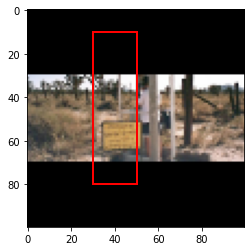

In [326]:
## testing

#print(torch.cuda.memory_summary(device=None, abbreviated=False))
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import copy

it = 0

for data in test_quantized_loader:
    if training == True:
        inputs, target = data[0].to(device), data[1].to(device) 
        input_img = copy.deepcopy(inputs[0])
    if training == False:
        inputs, target = data
        input_img = copy.deepcopy(inputs[0])
    
    
    
    #print(inputs)
    #print("targets shape", targets.shape)
    #print("inputs shape", inputs.shape)
    

    if color == 0:
        output_orig = model(inputs.float())
    else:
        output_orig = model(inputs[0].float())
    #print("ORIG: ", output_orig)
    
    ot2np = output_orig.cpu().detach().numpy()
    #tt2np = targets[it].cpu().detach().numpy()
    #print("output", ot2np)
    #print("target", tt2np)
    

    
    scaling = 10
    
    xmin_pred = scaling * np.argmax( ot2np[0][0:(round((dims[0]/10)))], axis=0 )
    ymin_pred = scaling * np.argmax( ot2np[0][(round((dims[0]/10))+1):(round((dims[0]/10)*2))], axis=0 )
    xmax_pred = scaling * np.argmax( ot2np[0][(round((dims[0]/10)*2)+1):(round((dims[0]/10)*3))], axis=0 )
    ymax_pred = scaling * np.argmax( ot2np[0][(round((dims[0]/10)*3)+1):(round((dims[0]/10)*4))], axis=0 )
    
    #xmin_targ = scaling * np.argmax( tt2np[0:(round((dims[0]/10)))], axis=0 )
    #ymin_targ = scaling * np.argmax( tt2np[(round((dims[0]/10))+1):(round((dims[0]/10)*2))], axis=0 )
    #xmax_targ = scaling * np.argmax( tt2np[(round((dims[0]/10)*2)+1):(round((dims[0]/10)*3))], axis=0 )
    #ymax_targ = scaling * np.argmax( tt2np[(round((dims[0]/10)*3)+1):(round((dims[0]/10)*4))], axis=0 )
    
    print("RECT: ", xmin_pred, ymin_pred, xmax_pred, ymax_pred)
    #print("TARG: ", xmin_targ, ymin_targ, xmax_targ, ymax_targ)
    
    input_img = torch.squeeze(input_img,1)
    if color == 1:
        input_img = torch.squeeze(input_img,0)
    
    
    im = input_img.cpu()
    im = np.moveaxis(np.asarray(im),0,2).astype('int32')

    # Create figure and axes
    fig, ax = plt.subplots()

    # Display the image
    ax.imshow(im)


    
    # Create a Rectangle patch
    pred_rect = patches.Rectangle((xmin_pred,ymin_pred), abs(xmax_pred-xmin_pred), abs(ymax_pred-ymin_pred), linewidth=2, edgecolor='r', facecolor='none')
    #targ_rect = patches.Rectangle((xmin_targ,ymin_targ), abs(xmax_targ-xmin_targ), abs(ymax_targ-ymin_targ), linewidth=2, edgecolor='g', facecolor='none')

    # Add the patch to the Axes
    ax.add_patch(pred_rect)
    #ax.add_patch(targ_rect)

    plt.show()
    
    it += 1
    
    #break#quit()

#print(model(x))
#print(y)

ORIG:  [[-3.6934037  -1.3572146  -0.9567251  -2.7663453  -1.7057889  -4.3534703
  -5.1025343  -0.19282842 -3.2706656  -3.1000862  -4.8281245   0.57848513
   0.72681457 -1.6019585  -2.158194   -3.908482   -1.4684616  -3.144585
  -2.9369235   1.1050545  -4.1458087  -0.67489916 -2.9814224  -2.899841
  -2.4771025  -0.76389664  0.0074164   1.0531392  -3.389329   -2.543851
  -2.017281    1.1940523  -4.776209   -1.3646312  -3.715653   -0.5265696
  -1.5352101  -0.79356265  0.10383064 -1.8986173 ]]
RECT:  70 80 60 0


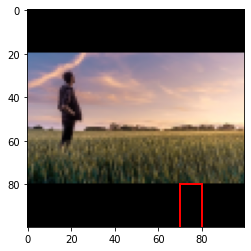

In [327]:
# test single images
import math
import copy
import matplotlib.pyplot as plt
import matplotlib.patches as patches

img = cv2.imread("test1.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # this converts it into RGB
top = math.floor((500 - img.shape[0]) / 2)
bottom = math.ceil((500 - img.shape[0]) / 2)
left = math.floor((500 - img.shape[1]) / 2)
right = math.ceil((500 - img.shape[1]) / 2)
img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)
img1 = cv2.resize(img, dims, interpolation = cv2.INTER_AREA)# resize img to fit dims
img1 = np.moveaxis(np.asarray(img1), -1, 0)

img = cv2.imread("test2.jpg")
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # this converts it into RGB
top = math.floor((500 - img.shape[0]) / 2)
bottom = math.ceil((500 - img.shape[0]) / 2)
left = math.floor((500 - img.shape[1]) / 2)
right = math.ceil((500 - img.shape[1]) / 2)
img = cv2.copyMakeBorder(img, top, bottom, left, right, cv2.BORDER_CONSTANT)
img2 = cv2.resize(img, dims, interpolation = cv2.INTER_AREA)# resize img to fit dims
img2 = np.moveaxis(np.asarray(img2), -1, 0)
#plt.imshow(img2)

from torchvision import transforms

img1 = torch.from_numpy(img2).clone().detach()
img2 = torch.from_numpy(img2).clone().detach()


input_img = copy.deepcopy(img1)

if training == True:
    img1 = img1.to(device)


img1 = torch.unsqueeze(img1,0)
output_orig = model(img1.float())
output_orig = output_orig.cpu().detach().numpy()
print("ORIG: ", output_orig)
#print(int(round(float(output_orig[0][0]))))

xmin = scaling * np.argmax( output_orig[0][0:(round((dims[0]/10)))], axis=0 )
ymin = scaling * np.argmax( output_orig[0][(round((dims[0]/10))+1):(round((dims[0]/10)*2))], axis=0 )
xmax = scaling * np.argmax( output_orig[0][(round((dims[0]/10)*2)+1):(round((dims[0]/10)*3))], axis=0 )
ymax = scaling * np.argmax( output_orig[0][(round((dims[0]/10)*3)+1):(round((dims[0]/10)*4))], axis=0 )

print("RECT: ", xmin, ymin, xmax, ymax)

input_img = torch.squeeze(input_img,1)
input_img = torch.squeeze(input_img,0)
#print(inputs_net)


im = input_img.cpu()
im = np.moveaxis(np.asarray(im),0,2).astype('int32')

# Create figure and axes
fig, ax = plt.subplots()

# Display the image
ax.imshow(im)



# Create a Rectangle patch
rect = patches.Rectangle((xmin,ymin), abs(xmax-xmin), abs(ymax-ymin), linewidth=2, edgecolor='r', facecolor='none')

# Add the patch to the Axes
ax.add_patch(rect)

plt.show()


In [328]:
# Save the Brevitas model to disk
torch.save(model.state_dict(), "state_dict_self-trained.pth")

In [329]:
from copy import deepcopy

modified_model = deepcopy(model)

W_orig = modified_model.conv1.weight.data.cpu().detach().numpy()
W_orig.shape
#W_orig = modified_model[0].weight.data.detach().numpy()
#W_orig.shape

(64, 3, 3, 3)

In [330]:
from brevitas.core.quant import QuantType
from brevitas.nn import QuantIdentity


class CybSecMLPForExport(nn.Module):
    def __init__(self, my_pretrained_model):
        super(CybSecMLPForExport, self).__init__()
        self.pretrained = my_pretrained_model
        #self.qnt_output = QuantIdentity(quant_type=QuantType.INT, bit_width=8, min_val=-1.0, max_val=1.0)
    
    def forward(self, x):
        # assume x contains bipolar {-1,1} elems
        # shift from {-1,1} -> {0,1} since that is the
        # input range for the trained network
        #x = (x + torch.tensor([1.0])) / 2.0  
        out = self.pretrained(x)
        #out = self.qnt_output(out)   # output as {-1,1}     # drop quantized output
        return out

model_for_export = CybSecMLPForExport(modified_model)

In [331]:
## Test IoU accuracy of model

#https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[2], boxB[2])
    yB = min(boxA[3], boxB[3])
    
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
    
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
    boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
    
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    
    # return the intersection over union value
    return iou

def test_padded_bipolar(model, test_loader):    
    # ensure model is in eval mode
    model.eval() 
    y_true = []
    y_pred = []
   
    its = 0
    
    with torch.no_grad():
        for data in test_loader:      
        
            inputs, target = data
            inputs = torch.squeeze(inputs,1)
            output_orig = model(inputs)
            #print(output_orig)
            #print(int(output_orig.size(dim=0)))

            pred = torch.zeros((4), dtype=torch.int64)
            true = torch.zeros((4), dtype=torch.int64)
            for i in range(int(output_orig.size(dim=0))):
                its += 1
                #print(output_orig.size())    
                #print(i)
                pred[0] = scaling * np.argmax( output_orig[i][0:(round((dims[0]/10)))], axis=0 )
                pred[1] = scaling * np.argmax( output_orig[i][(round((dims[0]/10))+1):(round((dims[0]/10)*2))], axis=0 )
                pred[2] = scaling * np.argmax( output_orig[i][(round((dims[0]/10)*2)+1):(round((dims[0]/10)*3))], axis=0 )
                pred[3] = scaling * np.argmax( output_orig[i][(round((dims[0]/10)*3)+1):(round((dims[0]/10)*4))], axis=0 )
                #print(pred)
                true[0] = target[i][0].float()
                true[1] = target[i][1].float()
                true[2] = target[i][2].float()
                true[3] = target[i][3].float()
                y_pred.append(pred.tolist())
                y_true.append(true.tolist())

             
    bbox_iou_sum = 0
    for i in range(len(y_true)):
        bbox_iou_sum += bb_intersection_over_union(y_true[i], y_pred[i])
        
    bbox_avg = bbox_iou_sum / its
    
    return bbox_avg

In [332]:
test_padded_bipolar(model_for_export, test_quantized_loader)

0.0

# Export to FINN-ONNX <a id="export_finn_onnx" ></a>


[ONNX](https://onnx.ai/) is an open format built to represent machine learning models, and the FINN compiler expects an ONNX model as input. We'll now export our network into ONNX to be imported and used in FINN for the next notebooks. Note that the particular ONNX representation used for FINN differs from standard ONNX, you can read more about this [here](https://finn.readthedocs.io/en/latest/internals.html#intermediate-representation-finn-onnx).

You can see below how we export a trained network in Brevitas into a FINN-compatible ONNX representation. Note how we create a `QuantTensor` instance with dummy data to tell Brevitas how our inputs look like, which will be used to set the input quantization annotation on the exported model.

In [333]:
import brevitas.onnx as bo
from brevitas.quant_tensor import QuantTensor

ready_model_filename = "cybsec-mlp-ready.onnx"
input_shape = (1, channels, resized_size, resized_size)
# create a QuantTensor instance to mark input as bipolar during export
input_a = np.random.randint(0, 1, size=input_shape).astype(np.float32)
scale = 1.0
input_t = torch.from_numpy(input_a * scale)
input_qt = QuantTensor(
    input_t, scale=torch.tensor(scale), bit_width=torch.tensor(8.0), signed=False
)

bo.export_finn_onnx(
    model_for_export, export_path=ready_model_filename, input_t=input_qt
)

print("Model saved to %s" % ready_model_filename)

Model saved to cybsec-mlp-ready.onnx


# Verify Exported ONNX Model in FINN

<font color="red">**Live FINN tutorial:** We recommend clicking **Cell -> Run All** when you start reading this notebook for "latency hiding".</font>

**Important: This notebook depends on the 1-train-mlp-with-brevitas notebook, because we are using the ONNX model that was exported there. So please make sure the needed .onnx file is generated before you run this notebook.**

**Also remember to 'close and halt' any other FINN notebooks, since Netron visualizations use the same port.**

In this notebook we will show how to import the network we trained in Brevitas and verify it in the FINN compiler. 
This verification process can actually be done at various stages in the compiler [as explained in this notebook](../bnn-pynq/tfc_end2end_verification.ipynb) but for this example we'll only consider the first step: verifying the exported high-level FINN-ONNX model.
Another goal of this notebook is to introduce you to the concept of *graph transformations* -- we'll be applying some transformations to the graph to make it executable for verification. 
Once this model is sucessfully verified, we'll generate an FPGA accelerator from it in the next notebook.

In [334]:
import onnx 
import torch 

**This is important -- always import onnx before torch**. This is a workaround for a [known bug](https://github.com/onnx/onnx/issues/2394).

# 1. Import model into FINN with ModelWrapper <a id="brevitas_import_visualization"></a>

Now that we have the model in .onnx format, we can work with it using FINN. To import it into FINN, we'll use the [`ModelWrapper`](https://finn.readthedocs.io/en/latest/source_code/finn.core.html#finn.core.modelwrapper.ModelWrapper). It is a wrapper around the ONNX model which provides several helper functions to make it easier to work with the model.

In [335]:
from finn.core.modelwrapper import ModelWrapper

ready_model_filename = "cybsec-mlp-ready.onnx"
model_for_sim = ModelWrapper(ready_model_filename)

# 2. Network preparation: Tidy-up transformations <a id="network_preparations"></a>

Before running the verification, we need to prepare our FINN-ONNX model. In particular, all the intermediate tensors need to have statically defined shapes. To do this, we apply some graph transformations to the model like a kind of "tidy-up" to make it easier to process. 

**Graph transformations in FINN.** The whole FINN compiler is built around the idea of transformations, which gradually transform the model into a synthesizable hardware description. Although FINN offers functionality that automatically calls a standard sequence of transformations (covered in the next notebook), you can also manually call individual transformations (like we do here), as well as adding your own transformations, to create custom flows. You can read more about these transformations in [this notebook](../bnn-pynq/tfc_end2end_example.ipynb).

In [336]:
from finn.transformation.general import GiveReadableTensorNames, GiveUniqueNodeNames, RemoveStaticGraphInputs
from finn.transformation.infer_shapes import InferShapes
from finn.transformation.infer_datatypes import InferDataTypes
from finn.transformation.fold_constants import FoldConstants

model_for_sim = model_for_sim.transform(InferShapes())
model_for_sim = model_for_sim.transform(FoldConstants())
model_for_sim = model_for_sim.transform(GiveUniqueNodeNames())
model_for_sim = model_for_sim.transform(GiveReadableTensorNames())
model_for_sim = model_for_sim.transform(InferDataTypes())
model_for_sim = model_for_sim.transform(RemoveStaticGraphInputs())

verif_model_filename = "cybsec-mlp-verification.onnx"
model_for_sim.save(verif_model_filename)

**Would the FINN compiler still work if we didn't do this?** The compilation step in the next notebook applies these transformations internally and would work fine, but we're going to use FINN's verification capabilities below and these require the tidy-up transformations.

# 3. Load the Dataset and the Brevitas Model <a id="load_dataset"></a>

We'll use some example data from the quantized UNSW-NB15 dataset (from the previous notebook) to use as inputs for the verification. 

In [337]:
import numpy as np
from torch.utils.data import TensorDataset

n_verification_inputs = batch_size
dataloader_iterator = iter(test_quantized_loader)
input_tensor, labels = next(dataloader_iterator) #get_preqnt_dataset(".", False)
print(input_tensor)
print(input_tensor.type())
print(input_tensor.shape)


tensor([[[[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]],

          [[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]]]])
torch.FloatTensor
torch.Size([1, 1, 3, 100, 100])


Let's also bring up the MLP we trained in Brevitas from the previous notebook. We'll compare its outputs to what is generated by FINN.

In [338]:
brevitas_model = model


# replace this with your trained network checkpoint if you're not
# using the pretrained weights
#trained_state_dict = torch.load("state_dict.pth")["models_state_dict"][0]
# Uncomment the following line if you previously chose to train the network yourself
trained_state_dict = torch.load("state_dict_self-trained.pth")

brevitas_model.load_state_dict(trained_state_dict, strict=False)

<All keys matched successfully>

In [339]:
def inference_with_brevitas(current_inp):
    brevitas_output = brevitas_model.forward(current_inp)
    """# apply sigmoid + threshold
    brevitas_output = torch.sigmoid(brevitas_output)
    brevitas_output = (brevitas_output.detach().numpy() > 0.5) * 1
    # convert output to bipolar
    brevitas_output = 2*brevitas_output - 1"""
    return brevitas_output

# 4. Compare FINN & Brevitas execution <a id="compare_brevitas"></a>

Let's make helper functions to execute the same input with Brevitas and FINN. For FINN, we'll use the [`finn.core.onnx_exec`](https://finn.readthedocs.io/en/latest/source_code/finn.core.html#finn.core.onnx_exec.execute_onnx) function to execute the exported FINN-ONNX on the inputs. Note that this ONNX execution is for verification only; not for accelerated execution.

Recall that the quantized values from the dataset are 593-bit binary {0, 1} vectors whereas our exported model takes 600-bit bipolar {-1, +1} vectors, so we'll have to preprocess it a bit before we can use it for verifying the ONNX model.

In [340]:
import finn.core.onnx_exec as oxe

def inference_with_finn_onnx(current_inp):
    finnonnx_in_tensor_name = model_for_sim.graph.input[0].name
    finnonnx_model_in_shape = model_for_sim.get_tensor_shape(finnonnx_in_tensor_name)
    finnonnx_out_tensor_name = model_for_sim.graph.output[0].name
    # convert input to numpy for FINN
    current_inp = current_inp.detach().numpy()
    # add padding and re-scale to bipolar
    current_inp = np.asarray(current_inp)
    #current_inp = 2*current_inp-1
    # reshape to expected input (add 1 for batch dimension)
    current_inp = current_inp.reshape(finnonnx_model_in_shape)
    # create the input dictionary
    input_dict = {finnonnx_in_tensor_name : current_inp} 
    # run with FINN's execute_onnx
    output_dict = oxe.execute_onnx(model_for_sim, input_dict)
    #get the output tensor
    finn_output = output_dict[finnonnx_out_tensor_name] 
    return finn_output

In [341]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = "cybsec-mlp-ready.onnx"

estimates_output_dir = "output_estimates_only"

#Delete previous run results if exist
if os.path.exists(estimates_output_dir):
    shutil.rmtree(estimates_output_dir)
    print("Previous run results deleted!")


cfg_estimates = build.DataflowBuildConfig(
    output_dir          = estimates_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = 10,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xczu3eg-sbva484-1-i",
    steps               = build_cfg.estimate_only_dataflow_steps,
    generate_outputs=[
        build_cfg.DataflowOutputType.ESTIMATE_REPORTS,
    ]
)

Previous run results deleted!


In [342]:
%%time
build.build_dataflow_cfg(model_file, cfg_estimates)

Building dataflow accelerator from cybsec-mlp-ready.onnx
Intermediate outputs will be generated in /tmp/finn_dev_nm
Final outputs will be generated in output_estimates_only
Build log is at output_estimates_only/build_dataflow.log
Running step: step_qonnx_to_finn [1/8]
Running step: step_tidy_up [2/8]
Running step: step_streamline [3/8]
Running step: step_convert_to_hls [4/8]


Traceback (most recent call last):
  File "/workspace/finn/src/finn/builder/build_dataflow.py", line 166, in build_dataflow_cfg
    model = transform_step(model, cfg)
  File "/workspace/finn/src/finn/builder/build_dataflow_steps.py", line 310, in step_create_dataflow_partition
    parent_model = model.transform(
  File "/workspace/finn-base/src/finn/core/modelwrapper.py", line 141, in transform
    (transformed_model, model_was_changed) = transformation.apply(
  File "/workspace/finn/src/finn/transformation/fpgadataflow/create_dataflow_partition.py", line 78, in apply
    parent_model = model.transform(
  File "/workspace/finn-base/src/finn/core/modelwrapper.py", line 141, in transform
    (transformed_model, model_was_changed) = transformation.apply(
  File "/workspace/finn-base/src/finn/transformation/create_generic_partitions.py", line 124, in apply
    assert (
AssertionError: cycle-free graph violated: partition depends on itself


Running step: step_create_dataflow_partition [5/8]
> /workspace/finn-base/src/finn/transformation/create_generic_partitions.py(124)apply()
    122                 for node in to_check:
    123                     if node is not None:
--> 124                         assert (
    125                             self.partitioning(node) != partition_id
    126                         ), """cycle-free graph violated: partition depends on itself"""

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
Build failed
CPU times: user 7.06 s, sys: 119 ms, total: 7.18 s
Wall time: 1min 42s


-1

We'll now examine the generated outputs from this build. If we look under the outputs directory, we'll find a subfolder with the generated estimate reports.

In [208]:
! ls {estimates_output_dir}

auto_folding_config.json  intermediate_models  report  time_per_step.json


In [209]:
! ls {estimates_output_dir}/report

estimate_layer_config_alternatives.json  estimate_network_performance.json
estimate_layer_cycles.json		 op_and_param_counts.json
estimate_layer_resources.json


We see that various reports have been generated as .json files. Let's examine the contents of the `estimate_network_performance.json` for starters. Here, we can see the analytical estimates for the performance and latency.

In [210]:
! cat {estimates_output_dir}/report/estimate_network_performance.json

{
  "critical_path_cycles": 62349362,
  "max_cycles": 9633792,
  "max_cycles_node_name": "StreamingFCLayer_Batch_4",
  "estimated_throughput_fps": 10.380128613945578,
  "estimated_latency_ns": 623493620.0
}

Since all of these reports are .json files, we can easily load them into Python for further processing. This can be useful if you are building your own design automation tools on top of FINN. Let's define a helper function and look at the `estimate_layer_cycles.json` report.

In [211]:
import json
def read_json_dict(filename):
    with open(filename, "r") as f:
        ret = json.load(f)
    return ret

In [212]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_cycles.json")

{'Thresholding_Batch_0': 67500,
 'ConvolutionInputGenerator_0': 592758,
 'StreamingFCLayer_Batch_0': 4205568,
 'StreamingMaxPool_Batch_0': 32856,
 'ConvolutionInputGenerator_1': 3000192,
 'StreamingFCLayer_Batch_1': 7962624,
 'StreamingMaxPool_Batch_1': 7776,
 'ConvolutionInputGenerator_2': 1345536,
 'StreamingFCLayer_Batch_2': 9469952,
 'ConvolutionInputGenerator_3': 2385408,
 'StreamingFCLayer_Batch_3': 8388608,
 'StreamingMaxPool_Batch_2': 1536,
 'ConvolutionInputGenerator_4': 463872,
 'StreamingFCLayer_Batch_4': 9633792,
 'ConvolutionInputGenerator_5': 342528,
 'StreamingFCLayer_Batch_5': 9437184,
 'StreamingMaxPool_Batch_3': 216,
 'StreamingFCLayer_Batch_6': 4718592,
 'StreamingFCLayer_Batch_7': 262144,
 'StreamingFCLayer_Batch_8': 30720}

Here, we can see the estimated number of clock cycles each layer will take. Recall that all of these layers will be running in parallel, and the slowest layer will determine the overall throughput of the entire neural network. FINN attempts to parallelize each layer such that they all take a similar number of cycles, and less than the corresponding number of cycles that would be required to meet `target_fps`. Additionally by summing up all layer cycle estimates one can obtain an estimate for the overall latency of the whole network. 

Finally, we can see the layer-by-layer resource estimates in the `estimate_layer_resources.json` report:

In [213]:
read_json_dict(estimates_output_dir + "/report/estimate_layer_resources.json")

{'Thresholding_Batch_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 16,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 428,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'StreamingFCLayer_Batch_0': {'BRAM_18K': 1,
  'BRAM_efficiency': 0.1875,
  'LUT': 507,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'StreamingMaxPool_Batch_0': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 596,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'StreamingFCLayer_Batch_1': {'BRAM_18K': 12,
  'BRAM_efficiency': 0.6666666666666666,
  'LUT': 829,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'StreamingMaxPool_Batch_1': {'BRAM_18K': 0,
  'BRAM_efficiency': 1,
  'LUT': 0,
  'URAM': 0,
  'URAM_efficiency': 1,
  'DSP': 0},
 'ConvolutionInputGenerator_2': {'BRAM_18K': 0,
 

This particular report is useful to determine whether the current configuration will fit into a particular FPGA. If you see that the resource requirements are too high for the FPGA you had in mind, you should consider lowering the `target_fps`.

**Note that the analytical models tend to over-estimate how much resources are needed, since they can't capture the effects of various synthesis optimizations.**

## Launch a Build: Stitched IP, out-of-context synth and rtlsim Performance <a id="build_ip_synth_rtlsim"></a>

Once we have a configuration that gives satisfactory estimates, we can move on to generating the accelerator. We can do this in different ways depending on how we want to integrate the accelerator into a larger system. For instance, if we have a larger streaming system built in Vivado or if we'd like to re-use this generated accelerator as an IP component in other projects, the `STITCHED_IP` output product is a good choice. We can also use the `OOC_SYNTH` output product to get post-synthesis resource and clock frequency numbers for our accelerator.

<font color="red">**Live FINN tutorial:** These next builds will take about 10 minutes to complete since multiple calls to Vivado and a call to RTL simulation are involved. While this is running, you can examine the generated files with noVNC -- it is running on **(your AWS URL):6080/vnc.html**

* Once the `step_hls_codegen [8/16]` below is completed, you can view the generated HLS code under its own folder for each layer: `/tmp/finn_dev_ubuntu/code_gen_ipgen_StreamingFCLayer_Batch_XXXXXX`
    
* Once the `step_create_stitched_ip [11/16]` below is completed, you can view the generated stitched IP in Vivado under `/home/ubuntu/finn/notebooks/end2end_example/cybersecurity/output_ipstitch_ooc_rtlsim/stitched_ip`
</font> 

In [99]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = "cybsec-mlp-ready.onnx"

rtlsim_output_dir = "output_ipstitch_ooc_rtlsim"

#Delete previous run results if exist
if os.path.exists(rtlsim_output_dir):
    shutil.rmtree(rtlsim_output_dir)
    print("Previous run results deleted!")

cfg_stitched_ip = build.DataflowBuildConfig(
    output_dir          = rtlsim_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    fpga_part           = "xczu3eg-sbva484-1-i",
    generate_outputs=[
        build_cfg.DataflowOutputType.STITCHED_IP,
        build_cfg.DataflowOutputType.RTLSIM_PERFORMANCE,
        build_cfg.DataflowOutputType.OOC_SYNTH,
    ]
)

Previous run results deleted!


In [101]:
%%time
build.build_dataflow_cfg(model_file, cfg_stitched_ip)

Building dataflow accelerator from cybsec-mlp-ready.onnx
Intermediate outputs will be generated in /tmp/finn_dev_nm
Final outputs will be generated in output_ipstitch_ooc_rtlsim
Build log is at output_ipstitch_ooc_rtlsim/build_dataflow.log
Running step: step_qonnx_to_finn [1/17]
Running step: step_tidy_up [2/17]
Running step: step_streamline [3/17]
Running step: step_convert_to_hls [4/17]
Running step: step_create_dataflow_partition [5/17]
Running step: step_target_fps_parallelization [6/17]
Running step: step_apply_folding_config [7/17]
Running step: step_generate_estimate_reports [8/17]
Running step: step_hls_codegen [9/17]
Running step: step_hls_ipgen [10/17]


multiprocessing.pool.RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/opt/conda/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.8/multiprocessing/pool.py", line 48, in mapstar
    return list(map(*args))
  File "/workspace/finn/src/finn/transformation/fpgadataflow/hlssynth_ip.py", line 69, in applyNodeLocal
    inst.ipgen_singlenode_code()
  File "/workspace/finn/src/finn/custom_op/fpgadataflow/hlscustomop.py", line 360, in ipgen_singlenode_code
    assert os.path.isdir(
AssertionError: IPGen failed: /tmp/finn_dev_nm/code_gen_ipgen_StreamingFCLayer_Batch_3_pt6ehma6/project_StreamingFCLayer_Batch_3/sol1/impl/ip not found. Check log under /tmp/finn_dev_nm/code_gen_ipgen_StreamingFCLayer_Batch_3_pt6ehma6
"""

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/workspace/finn/src/finn/builder/build_dataflow.py", line 166, in buil

> /opt/conda/lib/python3.8/multiprocessing/pool.py(771)get()
    769             return self._value
    770         else:
--> 771             raise self._value
    772 
    773     def _set(self, i, obj):

--KeyboardInterrupt--

KeyboardInterrupt: Interrupted by user
Build failed
CPU times: user 3min 17s, sys: 767 ms, total: 3min 18s
Wall time: 365d 11min 5s


-1

Why is e.g. `step_synthesize_bitfile` listed above even though we didn't ask for a bitfile in the output products? This is because we're using the default set of build steps, which includes `step_synthesize_bitfile`. Since its output product is not selected, this step will do nothing.

Among the output products, we will find the accelerator exported as a stitched IP block design:

In [297]:
! ls {rtlsim_output_dir}/stitched_ip

all_verilog_srcs.txt		       finn_vivado_stitch_proj.xpr
finn_vivado_stitch_proj.cache	       ip
finn_vivado_stitch_proj.gen	       make_project.sh
finn_vivado_stitch_proj.hw	       make_project.tcl
finn_vivado_stitch_proj.ip_user_files  vivado.jou
finn_vivado_stitch_proj.srcs	       vivado.log


We also have a few reports generated by these output products, different from the ones generated by `ESTIMATE_REPORTS`.

In [298]:
! ls {rtlsim_output_dir}/report

estimate_layer_resources_hls.json  rtlsim_performance.json
ooc_synth_and_timing.json


In `ooc_synth_and_timing.json` we can find the post-synthesis and maximum clock frequency estimate for the accelerator. Note that the clock frequency estimate here tends to be optimistic, since out-of-context synthesis is less constrained.

In [299]:
! cat {rtlsim_output_dir}/report/ooc_synth_and_timing.json

{
  "vivado_proj_folder": "/tmp/finn_dev_nm/synth_out_of_context_x6s1ci28/results_finn_design_wrapper",
  "LUT": 6037.0,
  "FF": 7483.0,
  "DSP": 0.0,
  "BRAM": 7.0,
  "WNS": 3.688,
  "": 0,
  "fmax_mhz": 158.42839036755387,
  "estimated_throughput_fps": 15654.979285331408
}

In `rtlsim_performance.json` we can find the steady-state throughput and latency for the accelerator, as obtained by rtlsim. If the DRAM bandwidth numbers reported here are below what the hardware platform is capable of (i.e. the accelerator is not memory-bound), you can expect the same steady-state throughput (excluding any software/driver overheads) in real hardware.

In [300]:
! cat {rtlsim_output_dir}/report/rtlsim_performance.json

{
  "cycles": 34287,
  "runtime[ms]": 0.34287,
  "throughput[images/s]": 2916.557295768075,
  "DRAM_in_bandwidth[Mb/s]": 1.6799370023624114,
  "DRAM_out_bandwidth[Mb/s]": 0.0583311459153615,
  "fclk[mhz]": 100.0,
  "N": 1,
  "latency_cycles": 34287
}

Finally, let's have a look at `final_hw_config.json`. This is the node-by-node hardware configuration determined by the FINN compiler, including FIFO depths, parallelization settings (PE/SIMD) and others. If you want to optimize your build further (the "advanced" method we mentioned under "Configuring the performance"), you can use this .json file as the `folding_config_file` for a new run to use it as a starting point for further exploration and optimizations.

In [301]:
! cat {rtlsim_output_dir}/final_hw_config.json

{
  "Defaults": {},
  "StreamingFIFO_0": {
    "ram_style": "auto",
    "depth": 2,
    "impl_style": "rtl"
  },
  "Thresholding_Batch_0": {
    "PE": 1,
    "ram_style": "distributed",
    "mem_mode": "const",
    "runtime_writeable_weights": 0
  },
  "StreamingFIFO_1": {
    "ram_style": "auto",
    "depth": 128,
    "impl_style": "rtl"
  },
  "ConvolutionInputGenerator_0": {
    "SIMD": 1,
    "ram_style": "distributed"
  },
  "StreamingDataWidthConverter_Batch_0": {
    "impl_style": "hls"
  },
  "StreamingFCLayer_Batch_0": {
    "PE": 1,
    "SIMD": 25,
    "ram_style": "auto",
    "resType": "lut",
    "mem_mode": "decoupled",
    "runtime_writeable_weights": 0
  },
  "StreamingDataWidthConverter_Batch_1": {
    "impl_style": "hls"
  },
  "StreamingFIFO_6": {
    "ram_style": "auto",
    "depth": 32,
    "impl_style": "rtl"
  },
  "StreamingDataWidthConverter_Batch_2": {
    "impl_style": "hls"
  },
  "StreamingFIFO_7": {
    "ram_style": "auto",
    "depth": 64,
    "impl_style"

## (Optional) Launch a Build: PYNQ Bitfile and Driver <a id="build_bitfile_driver"></a>

<font color="red">**Live FINN tutorial:** This section is not included in the hands-on tutorial due to the bitfile synthesis time (15-20 min). If you own a PYNQ board, we encourage you to uncomment the cells below to try it out on your own after the tutorial.</font>

In [17]:
import finn.builder.build_dataflow as build
import finn.builder.build_dataflow_config as build_cfg
import os
import shutil

model_file = "cybsec-mlp-ready.onnx"

final_output_dir = "output_final"

#Delete previous run results if exist
if os.path.exists(final_output_dir):
    shutil.rmtree(final_output_dir)
    print("Previous run results deleted!")

cfg = build.DataflowBuildConfig(
    output_dir          = final_output_dir,
    mvau_wwidth_max     = 80,
    target_fps          = 1000000,
    synth_clk_period_ns = 10.0,
    board               = "Pynq-Z1",
    shell_flow_type     = build_cfg.ShellFlowType.VIVADO_ZYNQ,
    generate_outputs=[
        build_cfg.DataflowOutputType.BITFILE,
        build_cfg.DataflowOutputType.PYNQ_DRIVER,
        build_cfg.DataflowOutputType.DEPLOYMENT_PACKAGE,
    ]
)

In [18]:
#%%time
#build.build_dataflow_cfg(model_file, cfg)

Building dataflow accelerator from cybsec-mlp-ready.onnx
Intermediate outputs will be generated in /tmp/finn_dev_ubuntu
Final outputs will be generated in output_final
Build log is at output_final/build_dataflow.log
Running step: step_tidy_up [1/16]
Running step: step_streamline [2/16]
Running step: step_convert_to_hls [3/16]
Running step: step_create_dataflow_partition [4/16]
Running step: step_target_fps_parallelization [5/16]
Running step: step_apply_folding_config [6/16]
Running step: step_generate_estimate_reports [7/16]
Running step: step_hls_codegen [8/16]
Running step: step_hls_ipgen [9/16]
Running step: step_set_fifo_depths [10/16]
Running step: step_create_stitched_ip [11/16]
Running step: step_measure_rtlsim_performance [12/16]
Running step: step_make_pynq_driver [13/16]
Running step: step_out_of_context_synthesis [14/16]
Running step: step_synthesize_bitfile [15/16]
Running step: step_deployment_package [16/16]
Completed successfully
CPU times: user 4.47 s, sys: 766 ms, tot

0

For our final build, the output products include the bitfile (and the accompanying .hwh file, also needed to execute correctly on PYNQ for Zynq platforms):

In [19]:
#! ls {final_output_dir}/bitfile

finn-accel.bit	finn-accel.hwh


The generated Python driver lets us execute the accelerator on PYNQ platforms with simply numpy i/o. You can find some notebooks showing how to use FINN-generated accelerators at runtime in the [finn-examples](https://github.com/Xilinx/finn-examples) repository.

In [20]:
#! ls {final_output_dir}/driver

driver.py  driver_base.py  finn  runtime_weights  validate.py


The reports folder contains the post-synthesis resource and timing reports:

In [21]:
#! ls {final_output_dir}/report

estimate_layer_resources_hls.json  post_synth_resources.xml
post_route_timing.rpt


Finally, we have the `deploy` folder which contains everything you need to copy onto the target board to get the accelerator running:

In [22]:
#! ls {final_output_dir}/deploy

bitfile  driver


## (Optional) Run on PYNQ board <a id="run_on_pynq"></a>

<font color="red">**Live FINN tutorial:** This section is not included in the hands-on tutorial due to the bitfile synthesis time (15-20 min) of the previous section. If you own a PYNQ board, we encourage you to uncomment the cells below to try it out on your own after the tutorial.</font>

To test the accelerator on the board, we'll put a copy of the dataset and a premade Python script that validates the accuracy into the `driver` folder, then make a zip archive of the whole deployment folder.

In [23]:
#! cp unsw_nb15_binarized.npz {final_output_dir}/deploy/driver

In [24]:
#! cp validate-unsw-nb15.py {final_output_dir}/deploy/driver

In [25]:
#! ls {final_output_dir}/deploy/driver

driver.py	finn		 unsw_nb15_binarized.npz  validate.py
driver_base.py	runtime_weights  validate-unsw-nb15.py


In [26]:
#from shutil import make_archive
#make_archive('deploy-on-pynq', 'zip', final_output_dir+"/deploy")

'/workspace/finn/notebooks/end2end_example/cybersecurity/deploy-on-pynq.zip'

You can now download the created zipfile (**File -> Open**, mark the checkbox next to the `deploy-on-pynq.zip` and select Download from the toolbar), then copy it to your PYNQ board (for instance via `scp` or `rsync`). Then, run the following commands **on the PYNQ board** to extract the archive and run the validation:

```shell
unzip deploy-on-pynq.zip -d finn-cybsec-mlp-demo
cd finn-cybsec-mlp-demo/driver
sudo python3.6 -m pip install bitstring
sudo python3.6 validate-unsw-nb15.py --batchsize 1000
```

You should see `Final accuracy: 91.868293` at the end. You may have noticed that the validation doesn't *quite* run at 1M inferences per second. This is because of the Python packing/unpacking and data movement overheads. To see this in more detail, the generated driver includes a benchmarking mode that shows the runtime breakdown:

```shell
sudo python3.6 driver.py --exec_mode throughput_test --bitfile ../bitfile/finn-accel.bit --batchsize 1000
cat nw_metrics.txt
```

```{'runtime[ms]': 1.0602474212646484,
 'throughput[images/s]': 943176.0737575893,
 'DRAM_in_bandwidth[Mb/s]': 70.7382055318192,
 'DRAM_out_bandwidth[Mb/s]': 0.9431760737575894,
 'fclk[mhz]': 100.0,
 'batch_size': 1000,
 'fold_input[ms]': 9.679794311523438e-05,
 'pack_input[ms]': 0.060115814208984375,
 'copy_input_data_to_device[ms]': 0.002428770065307617,
 'copy_output_data_from_device[ms]': 0.0005249977111816406,
 'unpack_output[ms]': 0.3773000240325928,
 'unfold_output[ms]': 6.818771362304688e-05}```

Here, the various `pack_input/unpack_output` calls show the overhead of packing/unpacking the inputs/outputs to convert from numpy arrays to the bit-contiguous data representation our accelerator expects. The `copy_input_data_to_device` and `copy_output_data_from_device` indicate the cost of moving the data between the CPU and accelerator memories. These overheads can dominate the execution time when running with small batch sizes.

Finally, we can see that `throughput[images/s]`, which is the pure hardware throughput without any software and data movement overheads, is close to 1M inferences per second.